## STT Transformer Protoype 
prototype desing of wrapping Watson STT to pySpark transformer
* api-key: dsc9p5YcmgSC7w93vadmN9QtHJpBNBmLbFtelcL5Fh3G
* endpoint: https://stream.watsonplatform.net/speech-to-text/api

### Test STT Package

In [3]:
import json
from ibm_watson import SpeechToTextV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

In [7]:
api_key = 'dsc9p5YcmgSC7w93vadmN9QtHJpBNBmLbFtelcL5Fh3G'
end_point = 'https://stream.watsonplatform.net/speech-to-text/api'

#### Test Connection

In [18]:
authenticator = IAMAuthenticator(api_key)
stt = SpeechToTextV1(
    authenticator=authenticator
)

stt.set_service_url(end_point)

speech_models = speech_to_text.list_models().get_result()
for model in speech_models['models'][:5]:
    print(model['name'])

es-CO_NarrowbandModel
nl-NL_NarrowbandModel
es-PE_NarrowbandModel
es-ES_NarrowbandModel
es-ES_BroadbandModel


#### Test sample data
* API:  
recognize(self, audio, content_type=None, model=None, language_customization_id=None, acoustic_customization_id=None, base_model_version=None, customization_weight=None, inactivity_timeout=None, keywords=None, keywords_threshold=None, max_alternatives=None, word_alternatives_threshold=None, word_confidence=None, timestamps=None, profanity_filter=None, smart_formatting=None, speaker_labels=None, customization_id=None, grammar_name=None, redaction=None, audio_metrics=None, end_of_phrase_silence_time=None, split_transcript_at_phrase_end=None, speech_detector_sensitivity=None, background_audio_suppression=None, **kwargs)
* docu: https://cloud.ibm.com/apidocs/speech-to-text?code=python#recognize-audio

In [93]:
#
# read audio file
#
def query_watson_stt(audio_file_path):
    # init client
    api_key = 'dsc9p5YcmgSC7w93vadmN9QtHJpBNBmLbFtelcL5Fh3G'
    end_point = 'https://stream.watsonplatform.net/speech-to-text/api'
    authenticator = IAMAuthenticator(api_key)
    stt = SpeechToTextV1(authenticator=authenticator)
    stt.set_service_url(end_point)
    with open(audio_file_path, "rb") as audio_file:
        response = stt.recognize(
            audio=audio_file,
            model='en-US_NarrowbandModel',
            profanity_filter=False,
            max_alternatives=1,
            split_transcript_at_phrase_end=False,
            content_type='audio/wav',
        ).get_result()

    transcripts = [doc['alternatives'][0]['transcript'].strip() for doc in response['results']]
    return '. '.join(transcripts) + '.'
    
print(query_watson_stt("data/sample_speech.wav"))       

painted the sockets in the wall dull green. the child crawled into the dense grass. bribes failed we're honest men work. trample the spark else the flames will spread. the hilt of the sword was carved with find designs a round hole was drilled through the thin board. footprints showed the path he took up the beach. she was waiting at my front lawn. event near the edge brought in fresh err. prod to the old mule with a crooked stick.


In [38]:
#
# simple result formatter
#
def simple_result_formatter(response):
    transcripts = [doc['alternatives'][0]['transcript'].strip() for doc in response['results']]
    return '. '.join(transcripts) + '.'

simple_result_formatter(result)    

"painted the sockets in the wall dull green. the child crawled into the dense grass. bribes failed we're honest men work. trample the spark else the flames will spread. the hilt of the sword was carved with find designs a round hole was drilled through the thin board. footprints showed the path he took up the beach. she was waiting at my front lawn. event near the edge brought in fresh err. prod to the old mule with a crooked stick."

### pySpark Transformer
define custome pySpark transformer

In [106]:
import string
import random
import pandas as pd
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import functions as F
from pyspark.sql.types import StringType
from pyspark.sql import DataFrame
from pyspark import keyword_only
from pyspark.ml.pipeline import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from matplotlib import pyplot as plt

In [ ]:
sc = SparkContext()

In [97]:
class WatsonSTT(Transformer):
    
    @keyword_only
    def __init__(self):
        super(WatsonSTT, self).__init__()    

    def _transform(self, df:DataFrame) -> DataFrame:
        stt_udf = F.udf(query_watson_stt, StringType())
        df = df.withColumn("audio_file_path", F.concat(F.lit('data/'), F.col("audio_file")))  
        df = df.withColumn("transcripts", stt_udf(F.col("audio_file_path")))
        return df


In [124]:
#
# build test dataframe
#
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

def fake_df(rows=10, num_partitions=10):
    df = pd.DataFrame({'audio_file': ['sample_speech.wav']*rows})
    df = sqlContext.createDataFrame(df)
    df = df.repartition(num_partitions)
    return df

foo = fake_df(30)
foo.rdd.getNumPartitions()

3

In [125]:
#
# test run transformer
#
def test_unit(row_count):
    df = fake_df(row_count)
    stt = WatsonSTT()
    df2 = stt.transform(df)
    df2.show(3)

+-----------------+--------------------+--------------------+
|       audio_file|     audio_file_path|         transcripts|
+-----------------+--------------------+--------------------+
|sample_speech.wav|data/sample_speec...|painted the socke...|
|sample_speech.wav|data/sample_speec...|painted the socke...|
|sample_speech.wav|data/sample_speec...|painted the socke...|
+-----------------+--------------------+--------------------+
only showing top 3 rows



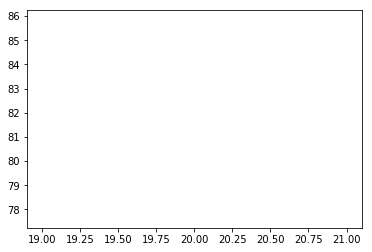

In [126]:
import time
size = [20]
time_ellapse = []

# run the experiment
for s in size:
    start = time.perf_counter()
    test_unit(s)
    delta = time.perf_counter() - start
    time_ellapse.append(delta)
    

# plot the result
plt.plot(size, time_ellapse)